Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 320, 320, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 160, 160, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 160, 160, 64)      18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 80, 80, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 80, 80, 128)       73856     
                                                                 
 up_sampling2d_22 (UpSampli  (None, 160, 160, 128)   

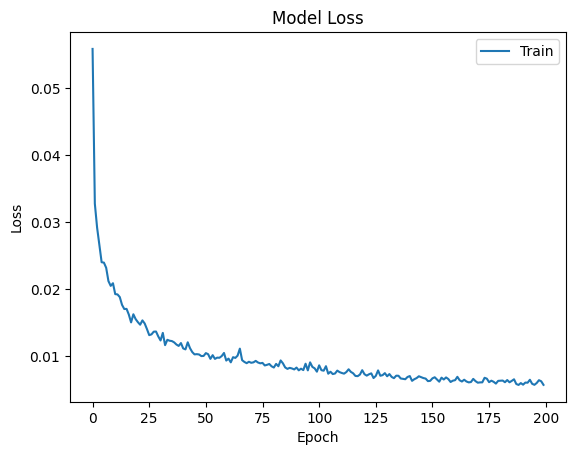

1/1 [==============================] - 0s 81ms/step
Sample predictions shape: (6, 320, 320, 1)
Prediction stats: min= 0.0047560167 max= 0.99918693


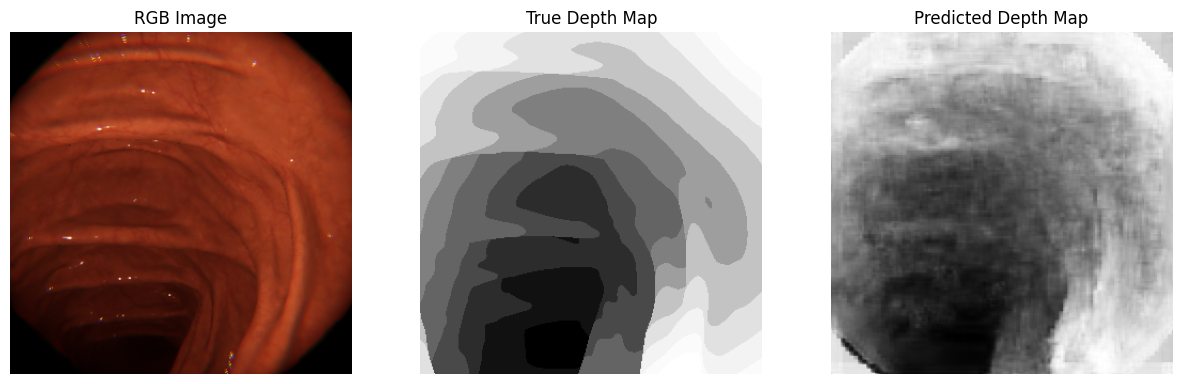

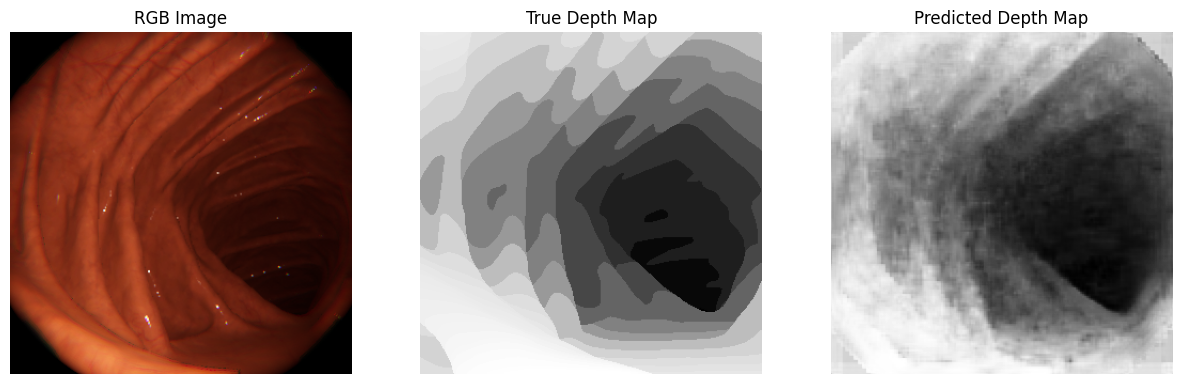

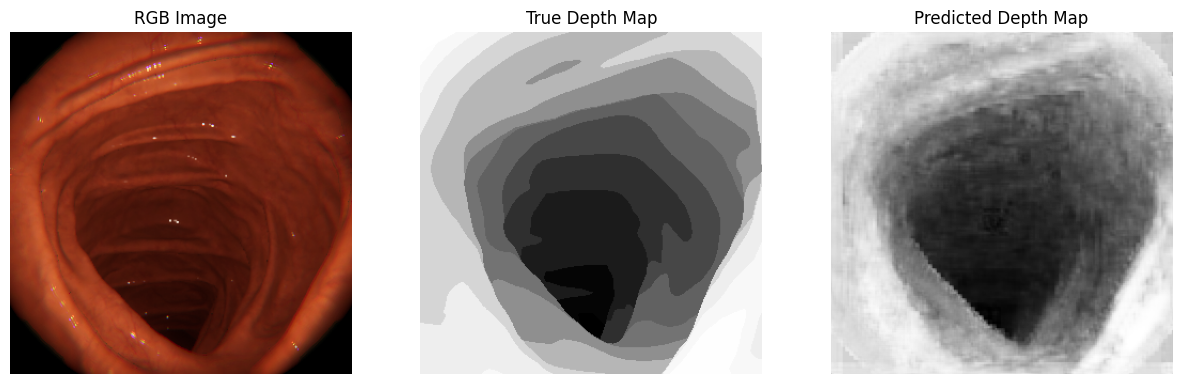

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import cv2  # Importing OpenCV for image processing

# Constants
HEIGHT = 320
WIDTH = 320
BATCH_SIZE = 6
base_path = '/content/drive/MyDrive/pics/realdataset/'
image_name = 'image_'
depth_name = 'aov_image_'

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_list, depth_list, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), shuffle=True):
        self.image_list = image_list
        self.depth_list = depth_list
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_list))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img_paths = [self.image_list[k] for k in indices]
        batch_depth_paths = [self.depth_list[k] for k in indices]
        X, y = self.__data_generation(batch_img_paths, batch_depth_paths)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_img_paths, batch_depth_paths):
        X = np.empty((len(batch_img_paths), *self.dim, 3))
        y = np.empty((len(batch_img_paths), *self.dim, 1))

        for i, (img_path, depth_path) in enumerate(zip(batch_img_paths, batch_depth_paths)):
            img = load_img(img_path, target_size=self.dim)
            img = img_to_array(img) / 255.0

            depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
            if depth.ndim == 3 and depth.shape[-1] == 4:  # Check if image has an alpha channel
                depth = cv2.cvtColor(depth, cv2.COLOR_BGRA2GRAY)  # Convert to grayscale
            elif depth.ndim == 3 and depth.shape[-1] == 3:
                depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)

            depth = cv2.resize(depth, self.dim, interpolation=cv2.INTER_AREA)
            depth = cv2.equalizeHist(depth)  # Enhance contrast using histogram equalization
            depth = np.expand_dims(depth, axis=-1) / 255.0  # Normalize and add channel dimension

            X[i] = img
            y[i] = depth

        return X, y

# Generate file lists
image_files = [f"{base_path}{image_name}{i:04d}.png" for i in range(1000)]
depth_files = [f"{base_path}{depth_name}{i:04d}.png" for i in range(1000)]

# Prepare the training and testing datasets
dataset = DataGenerator(image_files, depth_files, batch_size=BATCH_SIZE)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(HEIGHT, WIDTH, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Using sigmoid for output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

# After defining the model and before training
model.summary()  # To verify model architecture

# Training the model
history = model.fit(dataset, epochs=200, steps_per_epoch=57)  # Increased epochs or adjust as needed

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# Check a batch of predictions
sample_images, sample_depths = next(iter(dataset))
sample_predictions = model.predict(sample_images)
print("Sample predictions shape:", sample_predictions.shape)
print("Prediction stats: min=", np.min(sample_predictions), "max=", np.max(sample_predictions))

# Adjusting plot visualization code to enhance contrast if needed
for i in range(3):  # Visualizing three images for sanity check
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(sample_images[i], cmap='gray')
    axes[0].set_title("RGB Image")
    axes[0].axis('off')

    axes[1].imshow(sample_depths[i].squeeze(), cmap='gray')
    axes[1].set_title("True Depth Map")
    axes[1].axis('off')

    normalised_pred = np.clip(sample_predictions[i].squeeze(), 0, 1)
    axes[2].imshow(normalised_pred, cmap='gray')
    axes[2].set_title("Predicted Depth Map")
    axes[2].axis('off')

    plt.show()

In [19]:
# Save the entire model to a HDF5 file.
model.save('my_model.h5')  # Adjust the path and file name as necessary

# The '.h5' file extension indicates that the model should be saved in H5 format.
print("Model saved successfully!")

Model saved successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


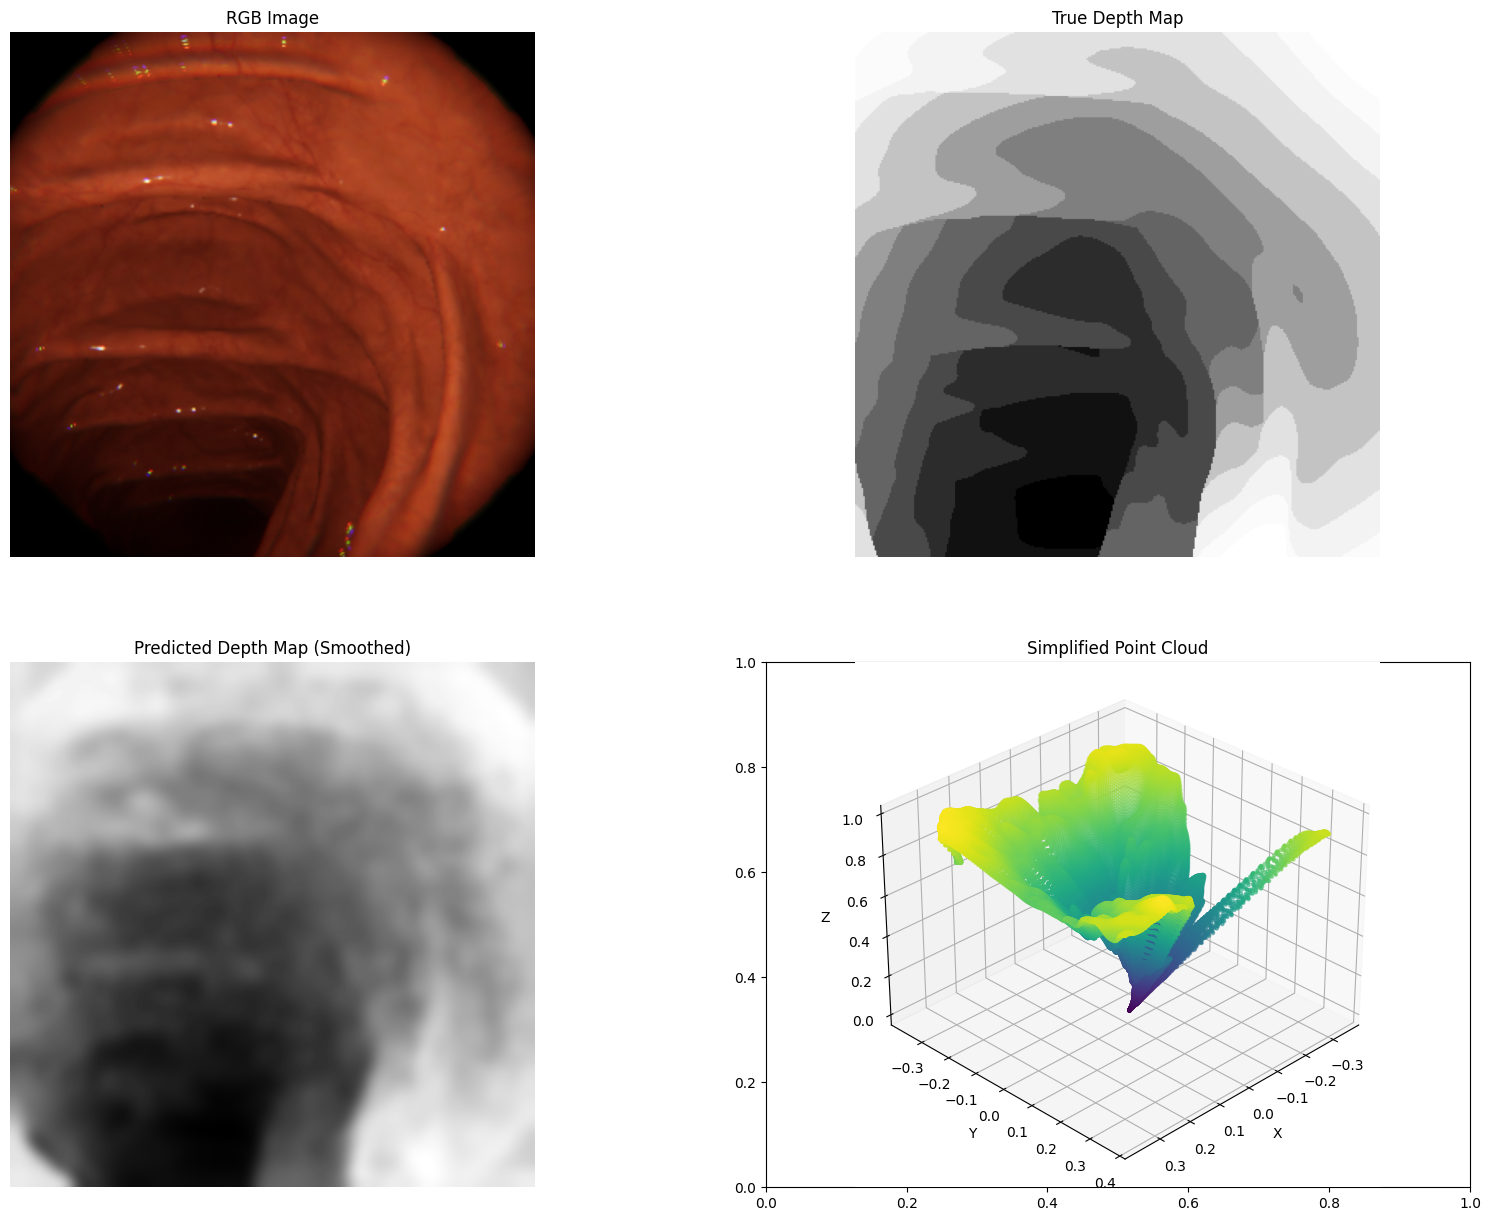

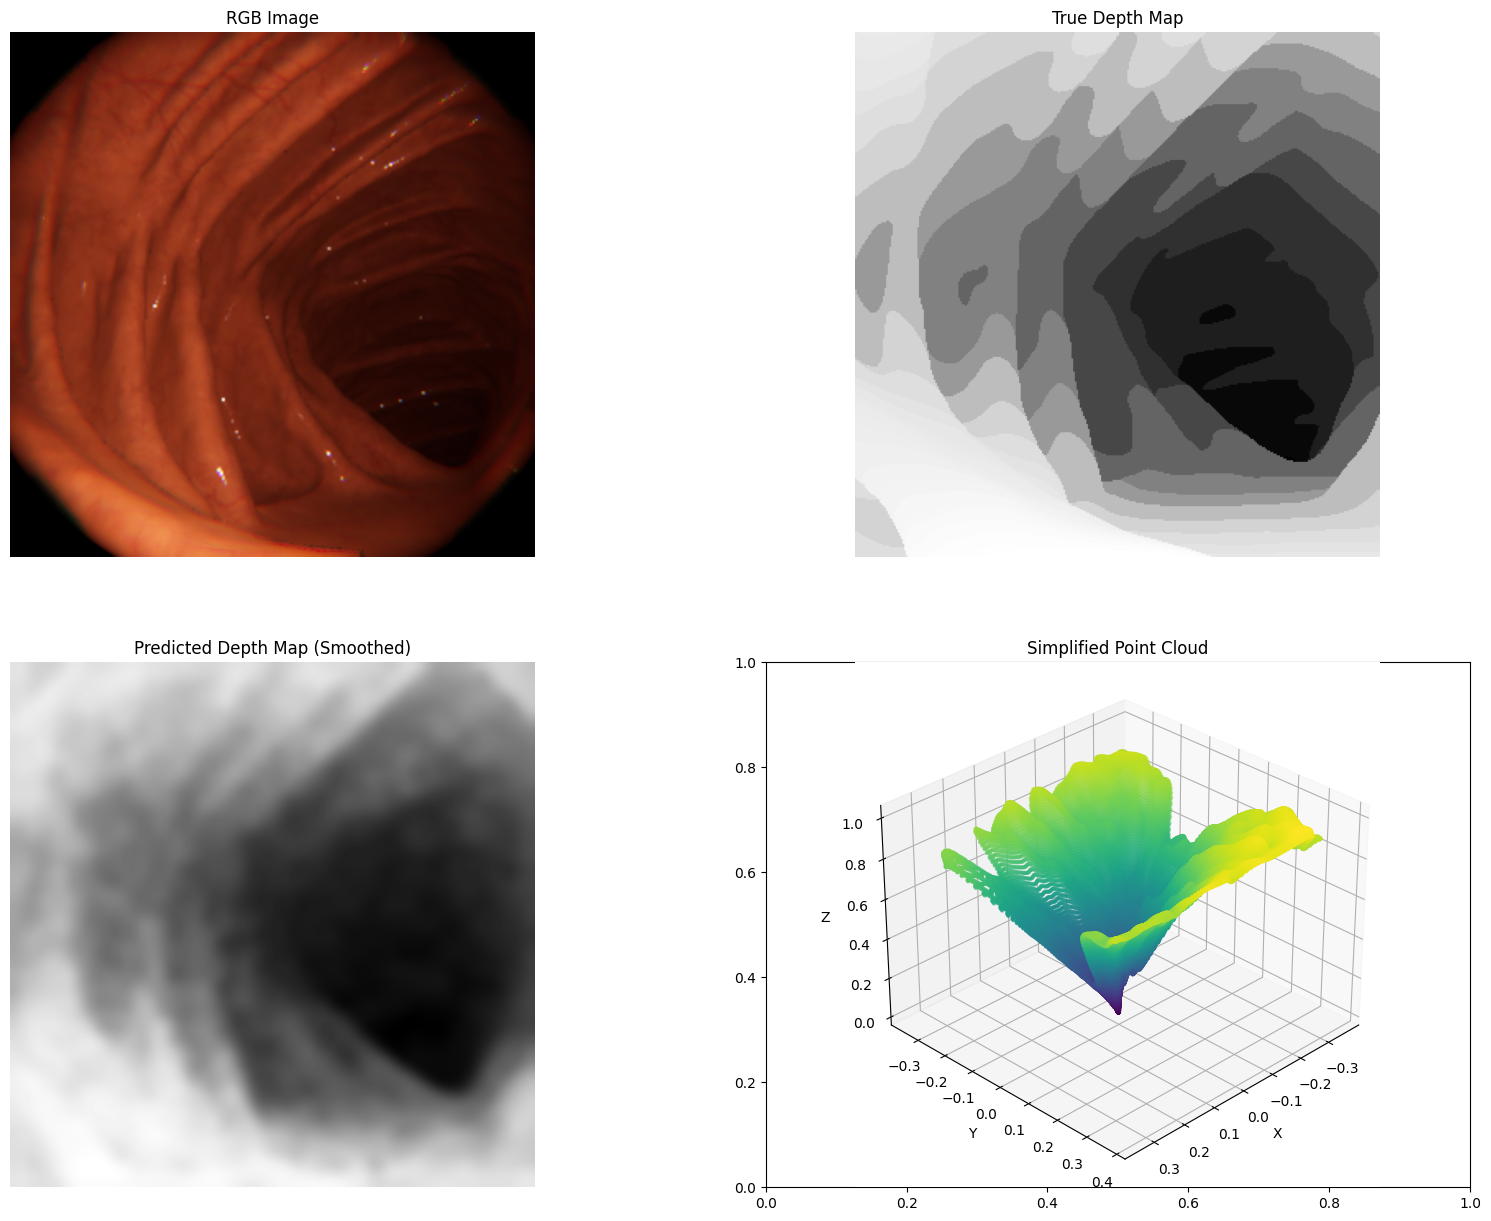

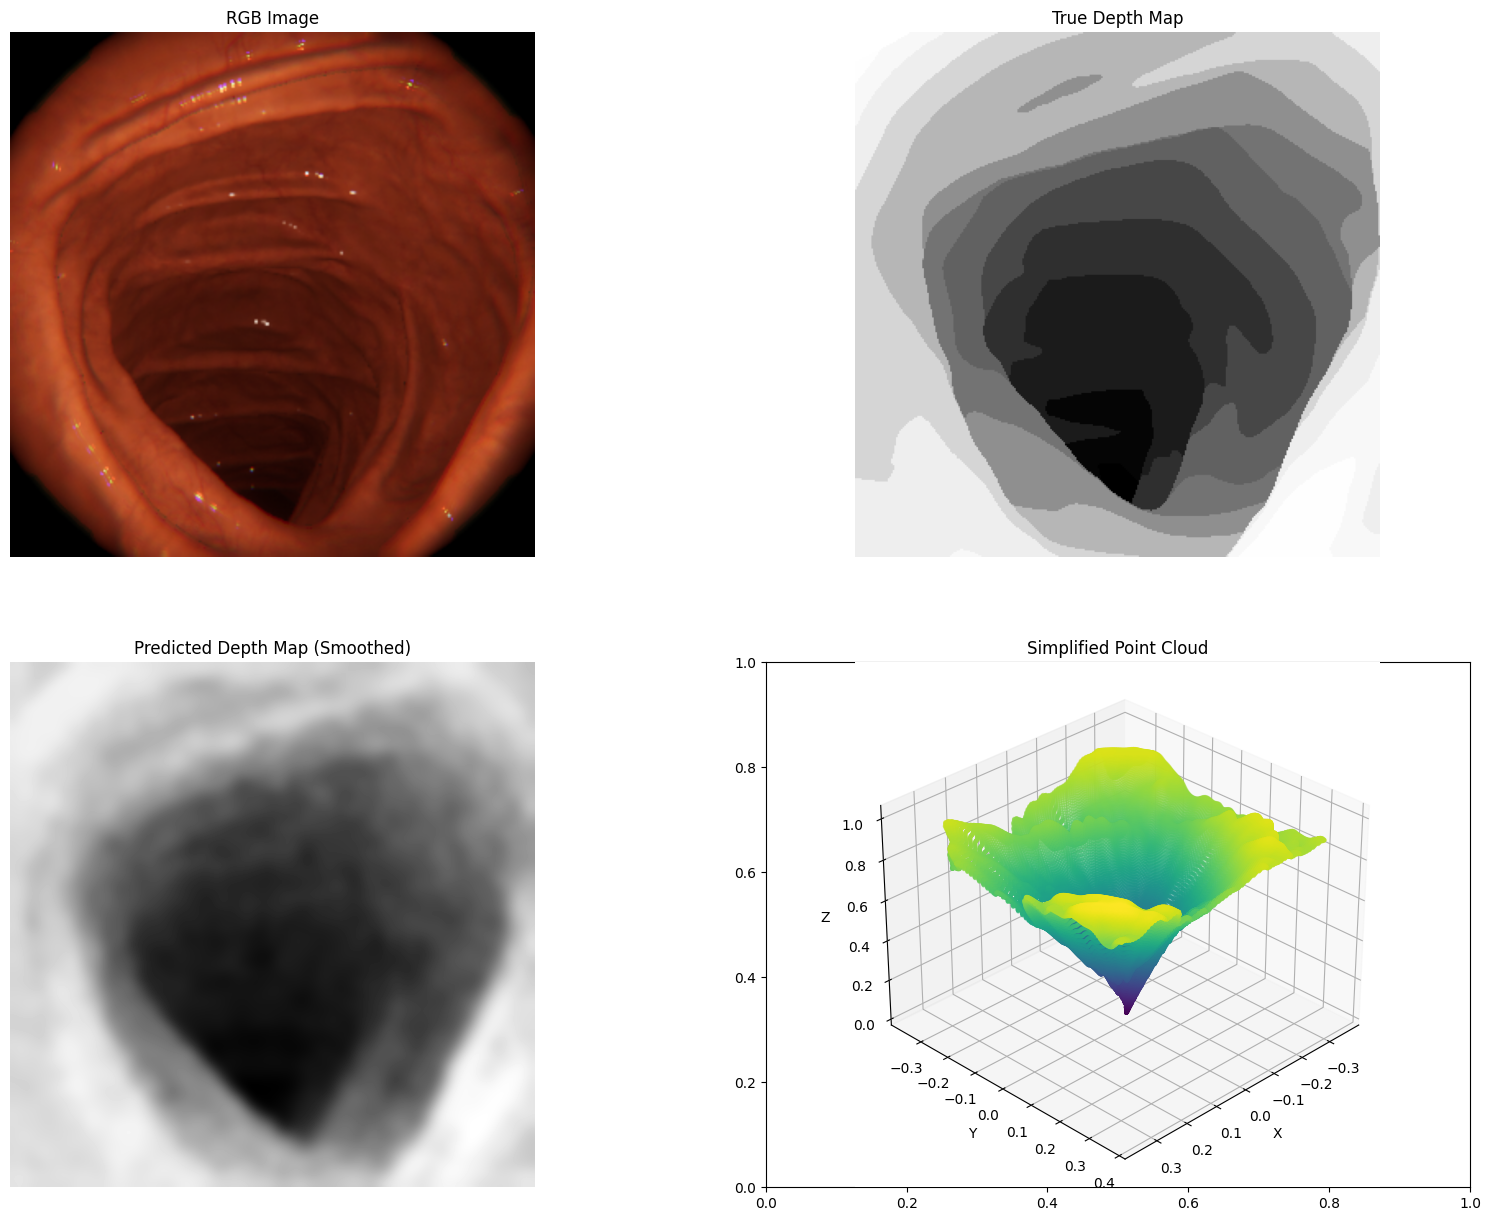

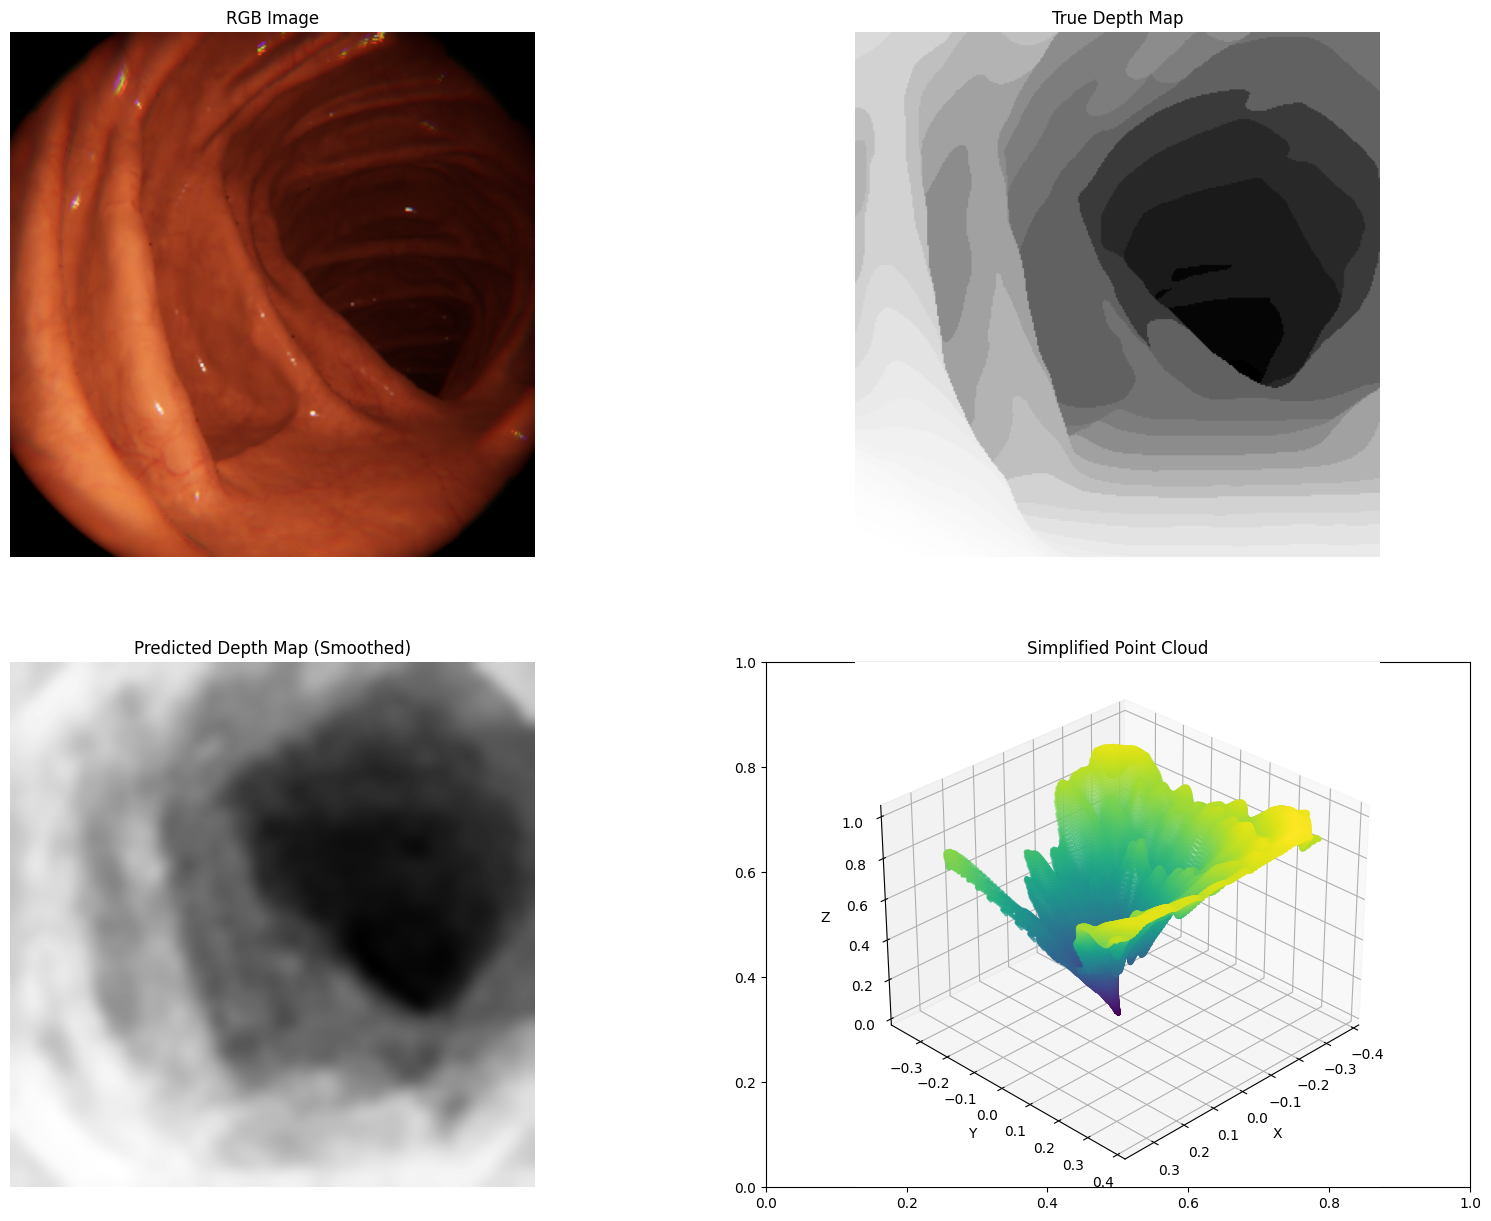

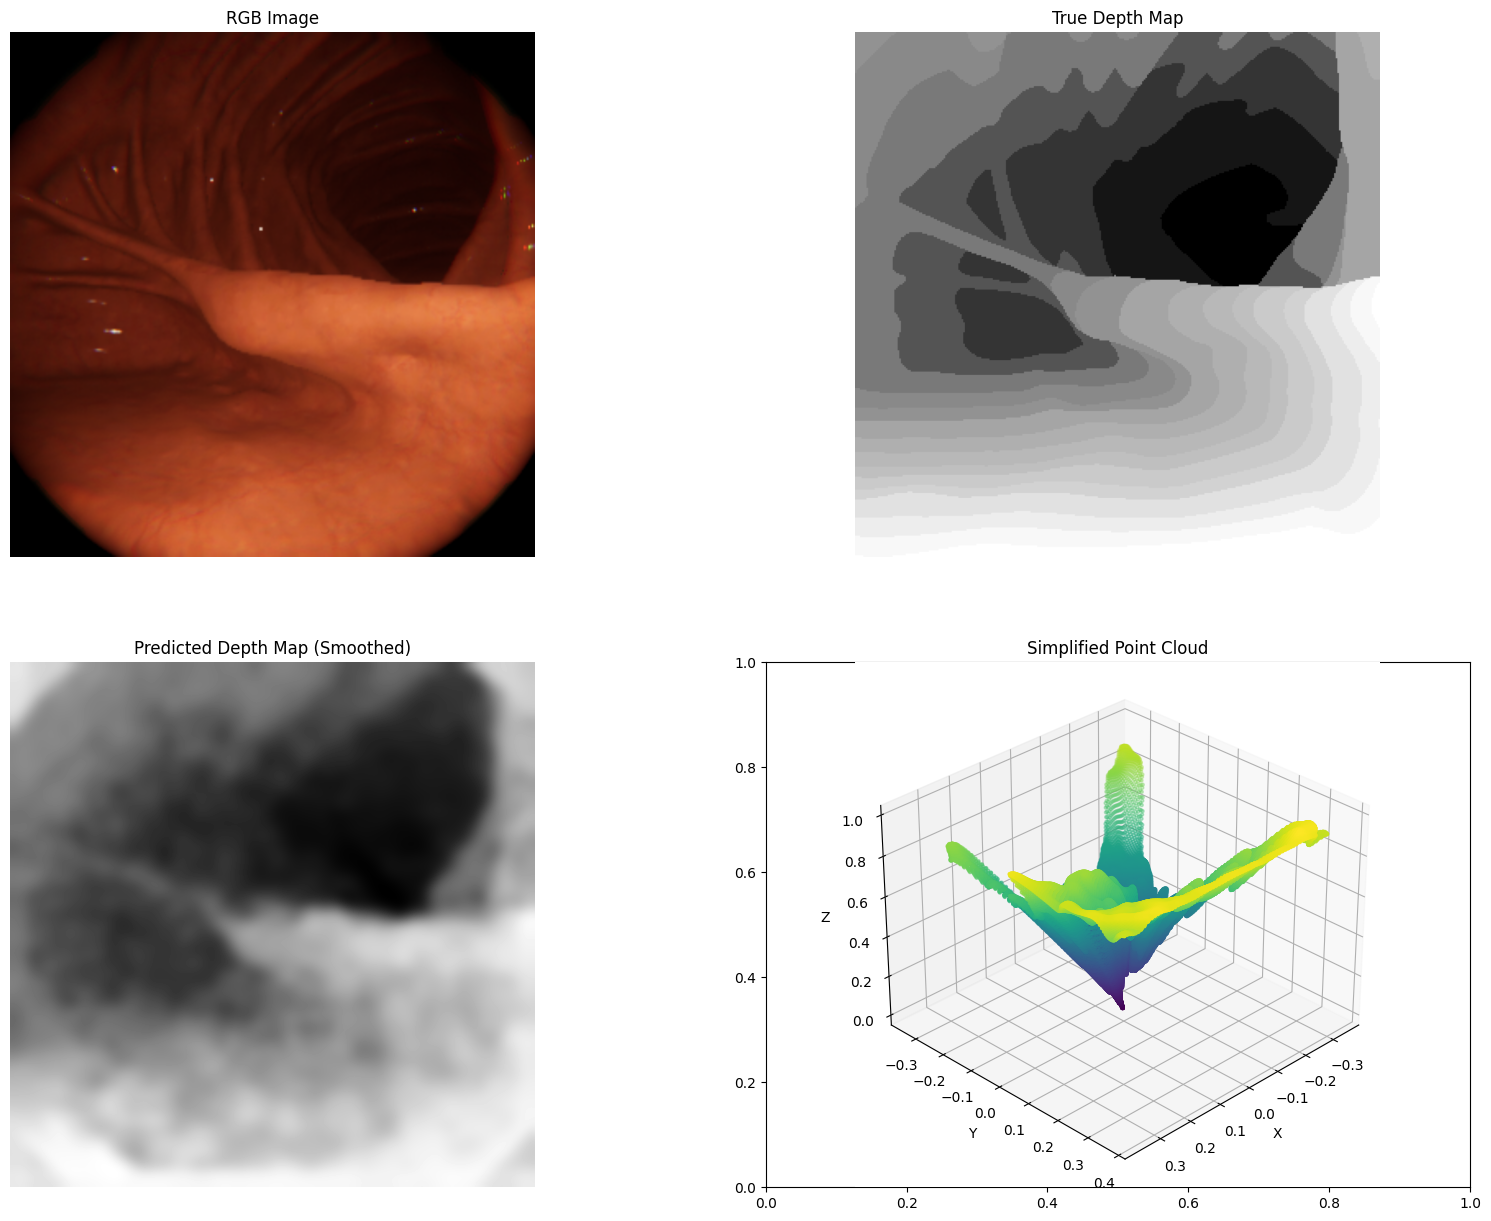

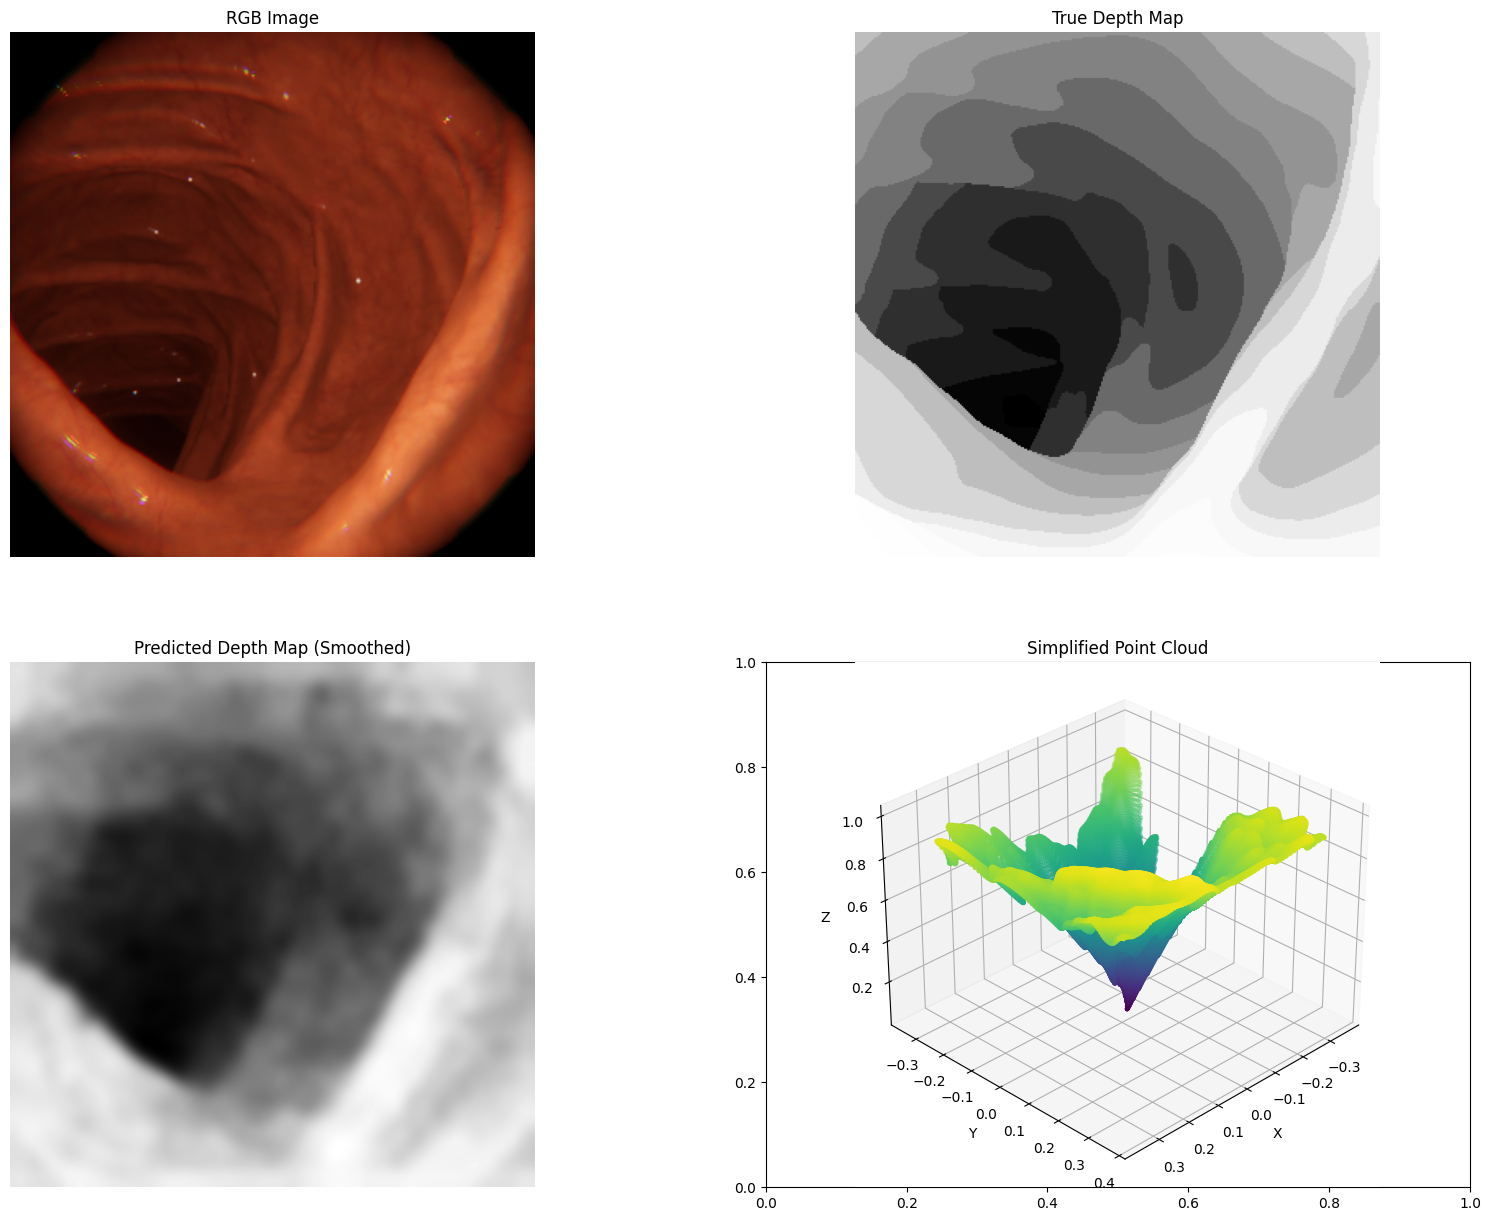

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D

# Define camera intrinsic parameters (example values, adjust as necessary)
fx = 1000  # Focal length in x-direction
fy = 1000  # Focal length in y-direction
cx = 384  # Principal point in x-direction (WIDTH / 2)
cy = 384  # Principal point in y-direction (HEIGHT / 2)

def depth_map_to_point_cloud(depth_map):
    points = []
    for v in range(depth_map.shape[0]):
        for u in range(depth_map.shape[1]):
            depth = depth_map[v, u]
            if depth == 0:
                continue
            Z = depth
            X = (u - cx) * depth / fx
            Y = (v - cy) * depth / fy
            points.append([X, Y, Z])
    return np.array(points)

def plot_point_cloud(ax, points):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, c=points[:, 2], cmap='viridis')
    ax.view_init(elev=30, azim=45)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Simplified Point Cloud')

# Assuming that sample_images, sample_depths, and sample_predictions contain the relevant data

HEIGHT, WIDTH = 768, 768

for index in range(6):  # Loop through the first 6 indices (from 0 to 5)
    rgb_img = sample_images[index]
    true_depth = sample_depths[index].squeeze()
    predicted_depth = sample_predictions[index].squeeze()

    # Resize images if needed
    rgb_img_resized = resize(rgb_img, (HEIGHT, WIDTH), anti_aliasing=True)
    predicted_depth_resized = resize(predicted_depth, (HEIGHT, WIDTH), mode='constant')

    # Filter predicted depth map
    smoothed_prediction = cv2.resize(predicted_depth_resized, (HEIGHT, WIDTH))
    smoothed_prediction = cv2.GaussianBlur(smoothed_prediction, (61, 61), 0)
    denoised_prediction = cv2.bilateralFilter(smoothed_prediction, d=9, sigmaColor=25, sigmaSpace=25)

    # Generate and simplify point cloud
    point_cloud = depth_map_to_point_cloud(denoised_prediction)
    simplified_point_cloud = point_cloud[::10]

    # Plot images and point cloud
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Displaying RGB Image
    axes[0, 0].imshow(rgb_img_resized)
    axes[0, 0].set_title("RGB Image")
    axes[0, 0].axis('off')

    # Displaying True Depth Map
    axes[0, 1].imshow(true_depth, cmap='gray')
    axes[0, 1].set_title("True Depth Map")
    axes[0, 1].axis('off')

    # Displaying Predicted Depth Map
    axes[1, 0].imshow(denoised_prediction, cmap='gray')
    axes[1, 0].set_title("Predicted Depth Map (Smoothed)")
    axes[1, 0].axis('off')

    # Plotting point cloud in the fourth subplot
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    plot_point_cloud(ax4, simplified_point_cloud)

    plt.show()